# Analysing Human & Human x LLM Bert Predictions. Why correct / incorrect?

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, pairwise_distances, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# Model Params
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_len = 256

# SPECIFY GPU
device = torch.device("mps")

/Users/jacobshort/anaconda3/envs/uni2_39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobshort/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobshort/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/jacobshort/anaconda3/envs/uni2_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# REQUIRED FUNCTIONS
def pre_process_data(data, tokenizer, max_len):
    text = data['text']
    labels = data['is_true']

    untruncated_tokenised_sequences = [(tokenizer.encode(text, truncation=False, add_special_tokens=True)) for text in text]

    tokenised_sequences = tokenizer.batch_encode_plus(
    text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True)

    tokenised_sequence_tensor = torch.tensor(tokenised_sequences['input_ids'])
    mask_tensor = torch.tensor(tokenised_sequences['attention_mask'])
    labels_tensor = torch.tensor(labels.tolist())

    return untruncated_tokenised_sequences, tokenised_sequence_tensor, mask_tensor, labels_tensor



def initialise_bert_model_unfrozen():
    # Load original BERT and freeze its parameters
    bert = AutoModel.from_pretrained('bert-base-uncased')
    for param in bert.parameters():
        param.requires_grad = True

    # Define the model architecture with classification head
    # Classification head: ReLu -> FC -> ReLu -> FC -> Softmax
    class BERT_Arch(nn.Module):

        # Define layers within the model (we use these layers in the forward pass)
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            self.dropout = nn.Dropout(0.1)
            self.relu = nn.ReLU()
            self.fc1 = nn.Linear(768, 512)
            self.fc2 = nn.Linear(512, 2)
            self.softmax = nn.LogSoftmax(dim=1)

        # Define forward pass (flow of data) through network
        def forward(self, sent_id, mask):
            # Pass the CLS token (BERT's output) to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.softmax(x)
            return x

    # Create an instance of BERT and place on GPU
    model = BERT_Arch(bert)
    model = model.to(device)

    return model



# FUNCTION TO PREDICT LABELS (USING BATCHING) & COMPUTE PERFORMANCE METRICS
def predictions(model, original_df, sequences, masks, labels):
    model = model.to(device)
    model.eval()
    all_preds = []
    batch_size = 32

    n_batches = (len(sequences) + batch_size - 1) // batch_size
    print(f"Total batches to process: {n_batches}")
    
    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            seq_batch = sequences[i:i+batch_size].to(device)
            mask_batch = masks[i:i+batch_size].to(device)
            
            preds = model(seq_batch, mask_batch)
            preds = preds.detach().cpu().numpy()
            all_preds.append(preds)

            
            # Progress update every 10 batches
            if (i // batch_size + 1) % 10 == 0:
                processed_batches = i // batch_size + 1
                remaining_batches = n_batches - processed_batches
                print(f"Processed {processed_batches} batches, {remaining_batches} batches remaining")
    
    all_preds=np.concatenate(all_preds, axis=0)
    predictions = np.argmax(all_preds, axis=1)

    text = original_df['text']
    text_pd = pd.DataFrame(text)
    text_pd = text_pd.iloc[:,0]

    correct = original_df['Misclassified']

    labels_numpy = labels.numpy()
    labels_pd = pd.DataFrame(labels_numpy)
    labels_pd = labels_pd.iloc[:,0]

    results_df = pd.DataFrame({'Text': text_pd, 'Predicted Label': predictions, 'Original Label': labels_pd, 'Misclassified':correct})
    results_df = results_df.dropna(subset=['Text'])
    
    return results_df

In [3]:
# DATASETS
human_bert_human_data_results = pd.read_csv('/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_bert.csv')
human_bert_human_data_results.rename(columns={'Text': 'text', 'Original Label': 'is_true'}, inplace=True)
human_bert_human_data_results['Misclassified'] = human_bert_human_data_results.apply(lambda row: 1 if row['Predicted Label'] != row['is_true'] else 0, axis=1)
human_bert_human_data_results_classified = human_bert_human_data_results[human_bert_human_data_results['Misclassified'] == 0]
human_bert_human_data_results_misclassified = human_bert_human_data_results[human_bert_human_data_results['Misclassified'] == 1]
_, human_bert_human_data_results_seq, human_bert_human_data_results_mask, human_bert_human_data_results_labels = pre_process_data(human_bert_human_data_results, tokenizer, max_len)

human_bert_llm_data_results = pd.read_csv('/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_bert.csv')
human_bert_llm_data_results.rename(columns={'Text': 'text', 'Original Label': 'is_true'}, inplace=True)
human_bert_llm_data_results['Misclassified'] = human_bert_llm_data_results.apply(lambda row: 1 if row['Predicted Label'] != row['is_true'] else 0, axis=1)
human_bert_llm_data_results_classified = human_bert_llm_data_results[human_bert_llm_data_results['Misclassified'] == 0]
human_bert_llm_data_results_misclassified = human_bert_llm_data_results[human_bert_llm_data_results['Misclassified'] == 1]
_, human_bert_llm_data_results_seq, human_bert_llm_data_results_mask, human_bert_llm_data_results_labels = pre_process_data(human_bert_llm_data_results, tokenizer, max_len)

human_and_llm_bert_human_data_results = pd.read_csv('/Applications/AI/msc_project/predictions/my_politifact_test_predictions_human_and_llm_bert.csv')
human_and_llm_bert_human_data_results.rename(columns={'Text': 'text', 'Original Label': 'is_true'}, inplace=True)
human_and_llm_bert_human_data_results['Misclassified'] = human_and_llm_bert_human_data_results.apply(lambda row: 1 if row['Predicted Label'] != row['is_true'] else 0, axis=1)
human_and_llm_bert_human_data_results_classified = human_and_llm_bert_human_data_results[human_and_llm_bert_human_data_results['Misclassified'] == 0]
human_and_llm_bert_human_data_results_misclassified = human_and_llm_bert_human_data_results[human_and_llm_bert_human_data_results['Misclassified'] == 1]
_, human_and_llm_bert_human_data_results_seq, human_and_llm_bert_human_data_results_mask, human_and_llm_bert_human_data_results_labels = pre_process_data(human_and_llm_bert_human_data_results, tokenizer, max_len)

human_and_llm_bert_llm_data_results = pd.read_csv('/Applications/AI/msc_project/predictions/my_llm_fake_politifact_test_predictions_human_and_llm_bert.csv')
human_and_llm_bert_llm_data_results.rename(columns={'Text': 'text', 'Original Label': 'is_true'}, inplace=True)
human_and_llm_bert_llm_data_results['Misclassified'] = human_and_llm_bert_llm_data_results.apply(lambda row: 1 if row['Predicted Label'] != row['is_true'] else 0, axis=1)
human_and_llm_bert_llm_data_results_classified = human_and_llm_bert_llm_data_results[human_and_llm_bert_llm_data_results['Misclassified'] == 0]
human_and_llm_bert_llm_data_results_misclassified = human_and_llm_bert_llm_data_results[human_and_llm_bert_llm_data_results['Misclassified'] == 1]
_, human_and_llm_bert_llm_data_results_seq, human_and_llm_bert_llm_data_results_mask, human_and_llm_bert_llm_data_results_labels = pre_process_data(human_and_llm_bert_llm_data_results, tokenizer, max_len)



# MODELS
human_model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_finetuned.pt"
human_model=initialise_bert_model_unfrozen()
human_model.load_state_dict(torch.load(human_model_path), strict=False)

human_and_llm_model_path = "/Applications/AI/msc_project/model_weights/bert_weights_politifact_human_llm_finetuned.pt"
human_and_llm_model=initialise_bert_model_unfrozen()
human_and_llm_model.load_state_dict(torch.load(human_and_llm_model_path), strict=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (707 > 512). Running this sequence through the model will result in indexing errors
/Users/jacobshort/anaconda3/envs/uni2_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/jacobshort/anaconda3/envs/uni2_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` t

_IncompatibleKeys(missing_keys=[], unexpected_keys=['bert.embeddings.position_ids'])

## Manual Inspection
- Nothing obvious

,text,Predicted Label,is_true,Misclassified
8,Editor's note: This story was originally publi...,0,1,1
9,The shooting of 18-year-old Michael Brown is a...,0,1,1
15,ARE YOU READY? GET IT NOW! Increase more than...,1,0,1
24,By Sen. Rand Paul (R-Ky.) Rumors are that Don...,0,1,1
27,"Claro, muy triste. Las tratan de ofrecer marav...",1,0,1
32,Democracy Now! has been selected as an Officia...,0,1,1
50,"James C. Dobson, Ph.D., is founder and chairma...",0,1,1
52,Today’s Headlines The most important news sto...,1,0,1
60,May 2014: Ben Hodzic allegedly voted at the po...,0,1,1
74,Republican Senator Mitch McConnell and Democra...,0,1,1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jacobshort/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobshort/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


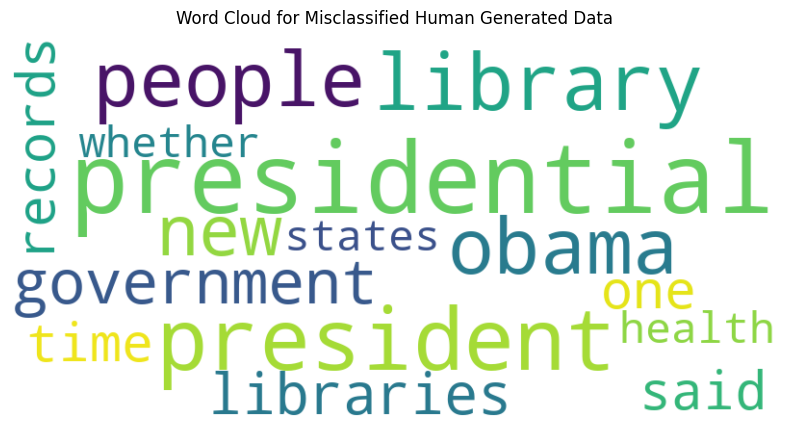

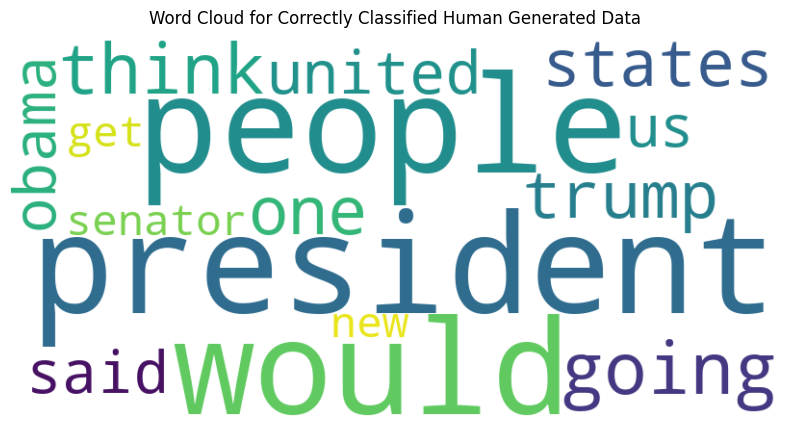

In [4]:
misclassified_df = human_bert_human_data_results[human_bert_human_data_results['Misclassified'] == 1]
display(misclassified_df)

# Word Clouds
nltk.download('punkt_tab')
nltk.download('stopwords')

# Combine data
misclassified_data = pd.concat([
    human_bert_human_data_results_misclassified['text'], 
    human_bert_llm_data_results_misclassified['text']
], ignore_index=True)

classified_data = pd.concat([
    human_bert_human_data_results_classified['text'], 
    human_bert_llm_data_results_classified['text']
], ignore_index=True)

# Preprocessing function to clean and tokenize text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stop_words]
    return words

# Function to generate a word cloud based on word frequencies
def generate_wordcloud(text_data, title, top_n=30):
    # Preprocess text data and count word frequencies
    all_words = []
    for text in text_data:
        words = preprocess_text(text)
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    top_words = dict(word_counts.most_common(top_n))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for top 30 words
generate_wordcloud(misclassified_data, 'Word Cloud for Misclassified Human Generated Data', top_n=15)
generate_wordcloud(classified_data, 'Word Cloud for Correctly Classified Human Generated Data', top_n=15)

## Probablities & Model Confidence
- We see bad predictions, have generally lower certainty. But to add an uncertain class would also involve many correctly classified points.

In [5]:
def get_probabilities(model, original_df, sequences, masks, labels):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_probs = []
    batch_size = 32

    n_batches = (len(sequences) + batch_size - 1) // batch_size
    print(f"Total batches to process: {n_batches}")
    
    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            seq_batch = sequences[i:i+batch_size].to(device)
            mask_batch = masks[i:i+batch_size].to(device)
            
            preds = model(seq_batch, mask_batch)
            preds = preds.detach().cpu().numpy()
            all_preds.append(preds)

            # Calculate probabilities
            probs = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True)
            all_probs.append(probs)
            
            # Progress update every 10 batches
            if (i // batch_size + 1) % 10 == 0:
                processed_batches = i // batch_size + 1
                remaining_batches = n_batches - processed_batches
                print(f"Processed {processed_batches} batches, {remaining_batches} batches remaining")
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    max_probs = np.max(all_probs, axis=1)
 
    prob_df = pd.DataFrame({
        'Probability': max_probs,
        'Misclassified': original_df['Misclassified']
    })

    return prob_df

Total batches to process: 6
Total batches to process: 14
Processed 10 batches, 4 batches remaining
Total batches to process: 6
Total batches to process: 14
Processed 10 batches, 4 batches remaining


,Probability,Misclassified
0,0.903650,0
1,0.781275,0
2,0.929183,0
3,0.953135,0
4,0.748818,0
...,...,...
171,0.922845,0
172,0.926113,0
173,0.916462,0
174,0.928348,0


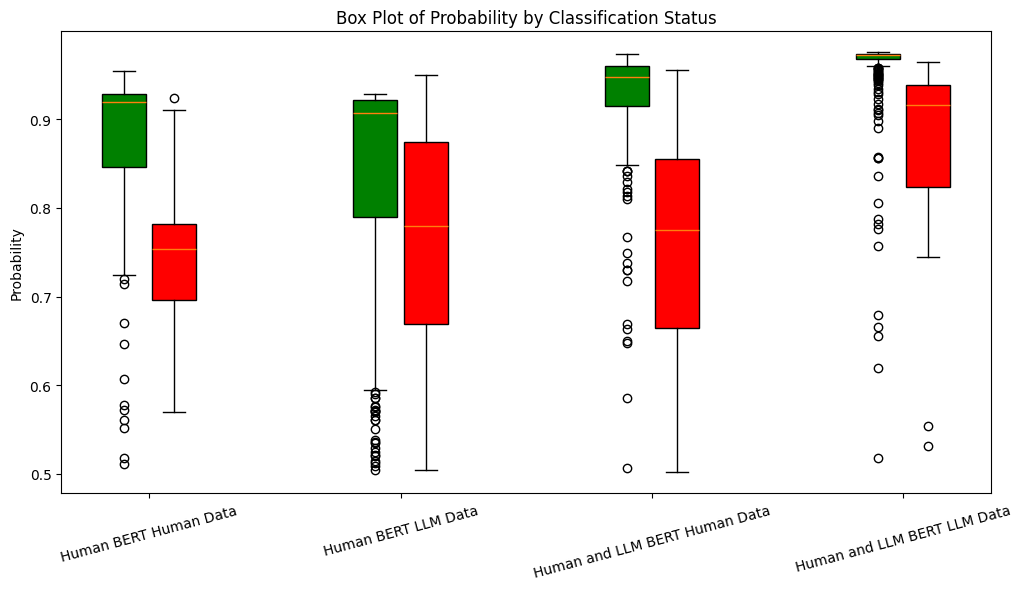

In [6]:
human_bert_human_data_prob_df = get_probabilities(model=human_model, original_df=human_bert_human_data_results, sequences=human_bert_human_data_results_seq, masks=human_bert_human_data_results_mask, labels=human_bert_human_data_results_labels)
human_bert_llm_data_prob_df = get_probabilities(model=human_model, original_df=human_bert_llm_data_results, sequences=human_bert_llm_data_results_seq, masks=human_bert_llm_data_results_mask, labels=human_bert_llm_data_results_labels)
human_and_llm_bert_human_data_prob_df = get_probabilities(model=human_and_llm_model, original_df=human_and_llm_bert_human_data_results, sequences=human_and_llm_bert_human_data_results_seq, masks=human_and_llm_bert_human_data_results_mask, labels=human_and_llm_bert_human_data_results_labels)
human_and_llm_bert_llm_data_prob_df = get_probabilities(model=human_and_llm_model, original_df=human_and_llm_bert_llm_data_results, sequences=human_and_llm_bert_llm_data_results_seq, masks=human_and_llm_bert_llm_data_results_mask, labels=human_and_llm_bert_llm_data_results_labels)
display(human_bert_human_data_prob_df)

# DataFrames dictionary for easy plotting
dfs = {
    "Human BERT Human Data": human_bert_human_data_prob_df,
    "Human BERT LLM Data": human_bert_llm_data_prob_df,
    "Human and LLM BERT Human Data": human_and_llm_bert_human_data_prob_df,
    "Human and LLM BERT LLM Data": human_and_llm_bert_llm_data_prob_df
}

# Create a new figure
plt.figure(figsize=(12, 6))
all_data = []
colors = []
positions = []
pos_index = 1

for i, (label, df) in enumerate(dfs.items()):
    # Data for Misclassified = 0 (Green)
    all_data.append(df['Probability'][df['Misclassified'] == 0])
    colors.append('green')
    positions.append(pos_index)

    # Data for Misclassified = 1 (Red)
    all_data.append(df['Probability'][df['Misclassified'] == 1])
    colors.append('red')
    positions.append(pos_index + 0.4)
    
    # Move to the next pair of positions
    pos_index += 2

# Create boxplot with specified positions
box = plt.boxplot(all_data, positions=positions, patch_artist=True, widths=0.35)

# Color the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set x-ticks and labels
labels = []
for label in dfs.keys():
    labels.append(f'{label}\nClassified')
    labels.append(f'{label}\nMisclassified')

plt.xticks([i + 0.2 for i in range(1, pos_index, 2)], list(dfs.keys()), rotation=15)
plt.ylabel("Probability")
plt.title("Box Plot of Probability by Classification Status")
plt.show()


## Clustering Approach to see if it clusters the incorrect predictions
https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
- It does not

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


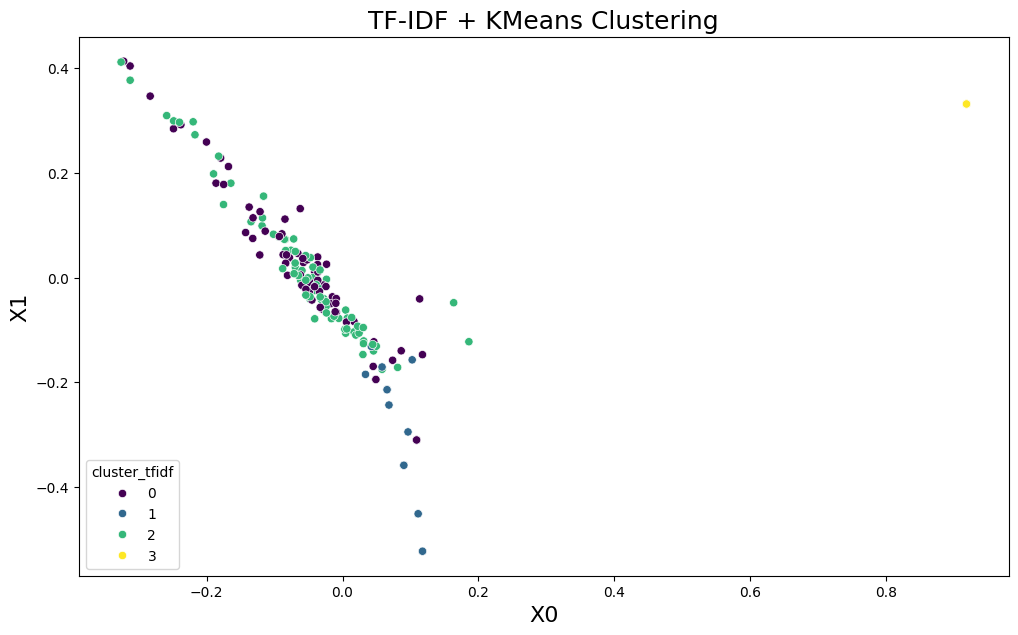

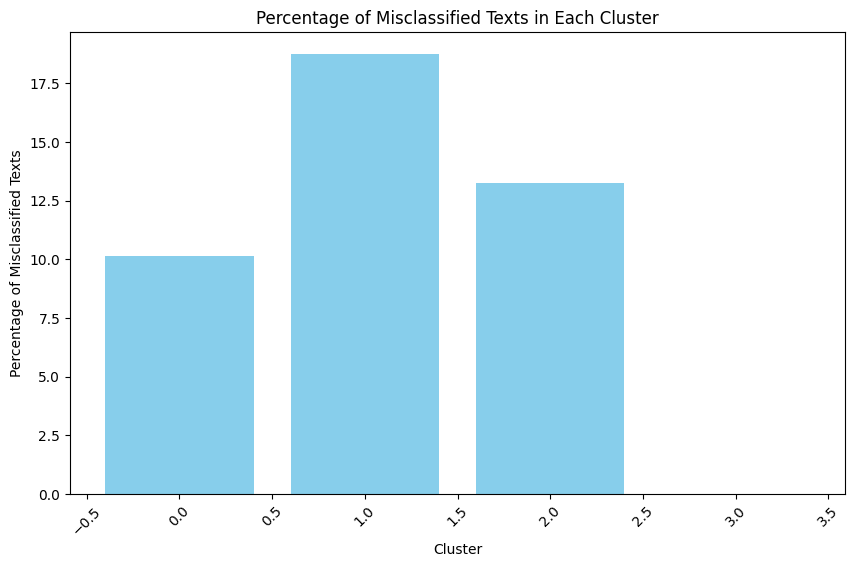

In [7]:
# Preprocess the text data
def preprocess_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    return text

# Apply preprocessing
human_bert_human_data_results['text_cleaned'] = human_bert_human_data_results['text'].apply(preprocess_text)

# Vectorise the text using TF-IDF
# Represents importance of words to the row of text
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X_tfidf = vectorizer.fit_transform(human_bert_human_data_results['text_cleaned']).toarray()

# Perform K-Means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
human_bert_human_data_results['cluster_tfidf'] = kmeans.fit_predict(X_tfidf)

# Dimensionality reduction using PCA for visualisation and interpretability
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X_tfidf)
human_bert_human_data_results['x0_tfidf'] = pca_vecs[:, 0]
human_bert_human_data_results['x1_tfidf'] = pca_vecs[:, 1]

# Plot the PCA results
plt.figure(figsize=(12, 7))
plt.title("TF-IDF + KMeans Clustering", fontdict={"fontsize": 18})
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
sns.scatterplot(data=human_bert_human_data_results, x='x0_tfidf', y='x1_tfidf', hue='cluster_tfidf', palette="viridis")
plt.show()

# Calculate misclassification rates
total_counts = human_bert_human_data_results.groupby('cluster_tfidf').size()
misclassified_counts = human_bert_human_data_results[human_bert_human_data_results['Predicted Label'] != human_bert_human_data_results['is_true']].groupby('cluster_tfidf').size()
percentage_misclassified = (misclassified_counts / total_counts) * 100
percentage_misclassified_df = percentage_misclassified.reset_index(name='misclassified_percentage')
percentage_misclassified_df['misclassified_percentage'] = percentage_misclassified_df['misclassified_percentage'].fillna(0)

# Bar Chart Visualization
plt.figure(figsize=(10, 6))
plt.bar(percentage_misclassified_df['cluster_tfidf'], percentage_misclassified_df['misclassified_percentage'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Misclassified Texts')
plt.title('Percentage of Misclassified Texts in Each Cluster')
plt.xticks(rotation=45)
plt.show()